In [12]:
import requests
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

In [13]:
polygon_api_key = os.getenv("POLYGON_API_KEY")
ticker = "META"

In [14]:
# Get date of earnings from 8 quarters ago
tick = yf.Ticker(ticker)
first_earnings = tick.earnings_dates.index[-1]

In [48]:
res = requests.get(
    f"https://api.polygon.io/vX/reference/financials",
    params={
        "apiKey": polygon_api_key, 
        "ticker": ticker, 

        "limit": 50
    }
)
if res.status_code != 200:
    print("Failed to fetch data: ", res.status_code)
data = res.json()
if "results" not in data:
    print("No data found")
reports = data["results"]

In [49]:
def extract_quarter_financials(quarter: dict):
    q = quarter["fiscal_period"]
    yr = quarter["fiscal_year"]
    eps = quarter["financials"]["income_statement"]["basic_earnings_per_share"]["value"]
    revenue = quarter["financials"]["income_statement"]["revenues"]["value"]
    income = quarter["financials"]["income_statement"]["income_loss_from_continuing_operations_before_tax"]["value"]
    return {
        "quarter": q,
        "year": yr,
        "eps": eps,
        "revenue": revenue,
        "income": income
    }


In [53]:
len(reports)

10

In [52]:
quarterly_financials = [
    extract_quarter_financials(q) for q in reports 
    # if q["fiscal_period"] in ["Q1", "Q2", "Q3", "Q4"]
]
df = pd.DataFrame(quarterly_financials)
df = df.set_index(["year", "quarter"])
yoy_change = (df - df.shift(-4)) / df.shift(-4) * 100
yoy_change = yoy_change.dropna().rename(columns=lambda x: f"{x}_yoy_change")
df = pd.concat([df, yoy_change], axis=1)
df["fiscal_period"] = df.index.get_level_values("quarter") + df.index.get_level_values("year").astype(str)
df["pre_tax_profit_margin"] = df["income"] / df["revenue"] * 100
df

eps       revenue        income  eps_yoy_change  \
year quarter                                                      
2024 Q2        5.31  3.907100e+10  1.510600e+10       18.000000   
     Q1        4.86  3.645500e+10  1.418300e+10       60.396040   
2023 Q4        5.46  4.011100e+10  1.680700e+10      147.058824   
     FY       15.19  1.349020e+11  4.742800e+10       76.013905   
     Q3        4.50  3.414600e+10  1.402000e+10      174.390244   
     Q2        3.03  3.199900e+10  9.293000e+09       22.672065   
     Q1        2.21  2.864500e+10  7.307000e+09             NaN   
2022 FY        8.63  1.166090e+11  2.881900e+10             NaN   
     Q3        1.64  2.771400e+10  5.576000e+09             NaN   
     Q2        2.47  2.882200e+10  8.186000e+09             NaN   

              revenue_yoy_change  income_yoy_change fiscal_period  \
year quarter                                                        
2024 Q2                14.423359           7.746077        Q22024   
     Q1                13.925435          52.620252        Q12024   
2023 Q4                40.027928         130.012317        Q42023   
     FY                15.687468          64.571984        FY2023   
     Q3                23.208487         151.434720        Q32023   
     Q2                11.022830          13.523088        Q22023   
     Q1                      NaN                NaN        Q12023   
2022 FY                      NaN                NaN        FY2022   
     Q3                      NaN                NaN        Q32022   
     Q2                      NaN                NaN        Q22022   

              pre_tax_profit_margin  
year quarter                         
2024 Q2                   38.662947  
     Q1                   38.905500  
2023 Q4                   41.901224  
     FY                   35.157374  
     Q3                   41.058982  
     Q2                   29.041533  
     Q1                   25.508815  
2022 FY                   24.714216  
     Q3                   20.119795  
     Q2                   28.401915

In [47]:
yoy_change

eps_yoy_change  revenue_yoy_change  income_yoy_change
year quarter                                                       
2024 Q2            75.247525           22.100691          62.552459
     Q1           119.909502           27.264793          94.101546
2023 Q4           232.926829           44.731904         201.416786
     Q3            82.186235           18.472001          71.268019

In [40]:
(3.9071 - 3.1999) / 3.1999 * 100

22.100690646582702

In [26]:
def make_bar_plot(
    df: pd.DataFrame,
    col: str, 
    title: str, 
    color="green", 
    target=7.5,
    n_quarters=4
):
    ax = df.iloc[:n_quarters].plot.bar(x="fiscal_period", y=col, color=color, rot=0)
    ax.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.2)
    ax.get_legend().remove()
    # Remove lines
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xlabel("")
    ax.set_title(title)
    ax.axhline(target, color='red', linewidth=0.5, linestyle='--')
    ax.tick_params(length=0)
    ax.set_ylim()
    ax.set_yticklabels([f"{int(x)}%" for x in ax.get_yticks()])
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='edge')

/var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_11276/1760033142.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(x)}%" for x in ax.get_yticks()])


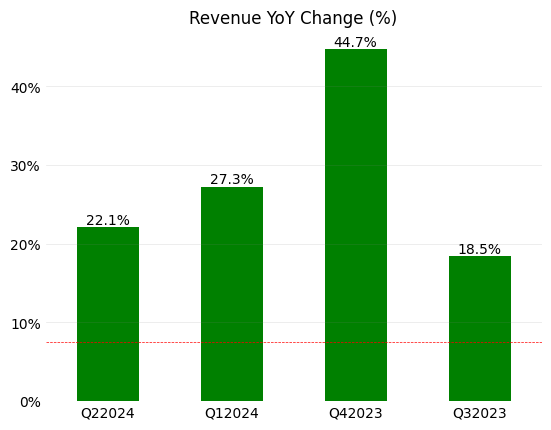

In [27]:
# Revenue YoY
make_bar_plot(df, "revenue_yoy_change", "Revenue YoY Change (%)", color="green", target=7.5)

/var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_11276/1760033142.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(x)}%" for x in ax.get_yticks()])


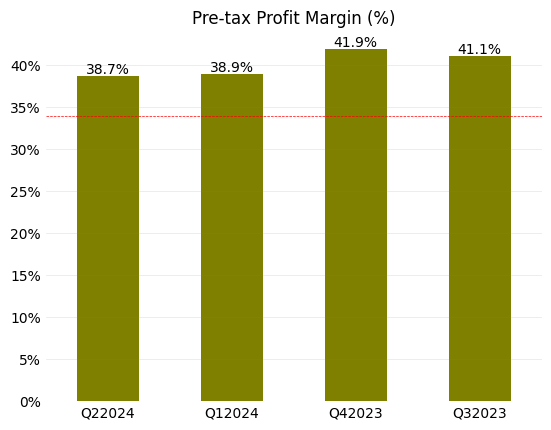

In [28]:
# PTPM
make_bar_plot(df, "pre_tax_profit_margin", "Pre-tax Profit Margin (%)", color="olive", target=34)

/var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_11276/1760033142.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(x)}%" for x in ax.get_yticks()])


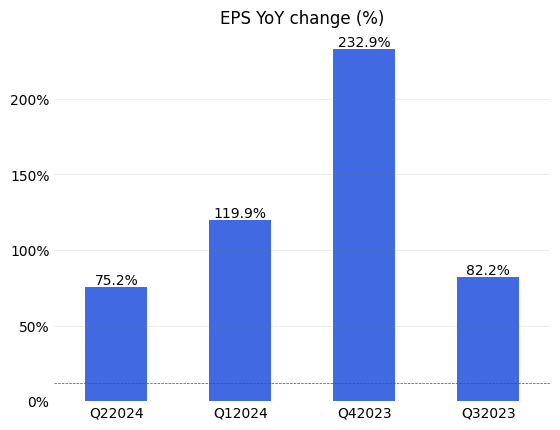

In [29]:
# PTPM
make_bar_plot(df, "eps_yoy_change", "EPS YoY change (%)", color="royalblue", target=12)

,Low,High
Buy,10,10
Hold,20,10
Sell,30,10


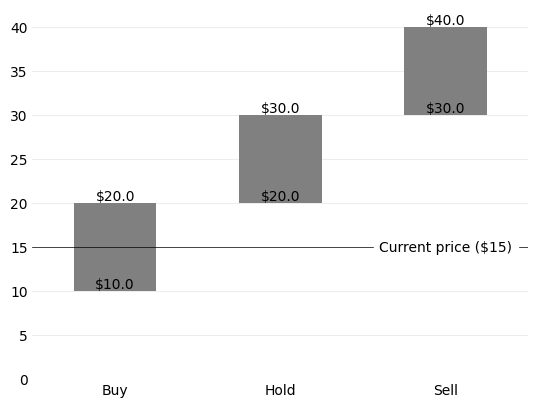

In [30]:
price = 15
ranges = pd.DataFrame(
    [[10, 10], [20, 10], [30, 10]],
    columns=["Low", "High"],
    index=["Buy", "Hold", "Sell"],
    
)
ax = ranges.plot.bar(stacked=True, color=[(0, 0, 0, 0), "grey"], 
rot=0)
ax.get_legend().remove()
ax.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.2)
for container in ax.containers:
    ax.bar_label(container, fmt='$%.1f', label_type='edge')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(length=0)
ax.axhline(price, color='black', linewidth=0.5)
ax.text(2, price, f"Current price (${price})", va='center', ha='center', backgroundcolor='white')
ranges